# LOADING LIBRARIES

In [1]:
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_wine
np.set_printoptions(precision=4)
sns.set()
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# DATASET

In [84]:
# TAKE THE DATA FROM JSON
with open('../Simulation/data_pos_sim_labelled_sep_motion.json') as f:
    data_dict = json.load(f)

data_list = [data_dict['LF_motion1'],data_dict['RF_motion1']]
data_array = np.array(data_list).T
temp_data_array = np.append(data_array[np.newaxis,0,:,0],data_array[np.newaxis,0,:,1],axis=0)
data_array = np.append(temp_data_array,data_array[np.newaxis,1,:,1],axis=0).T
angle_array = data_array[:,:2].astype(float)
print(angle_array.shape)
# 1st derivative
# we only keep the value of the right finger because it is the follower
gradient = []
for i in range(angle_array.shape[0]-1):
    rate_change = angle_array.T[1][i+1]-angle_array.T[1][i]
    gradient += [round(rate_change,3)]
print(len(gradient))

# 2nd derivative
double_gradient = []
for i in range(len(gradient)-1):
    rate_change = gradient[i+1]-gradient[i]
    double_gradient += [round(rate_change,3)]

print(len(double_gradient))
# we need to set up a min double gradient to identify the corners
threshold = 0.1
identified_corners = []
for i in range(len(double_gradient)):
    if abs(double_gradient[i]) > threshold:
        identified_corners += [angle_array[i].tolist()]
identified_corners = np.array(identified_corners)
print(identified_corners)

(98, 2)
97
96
[[72.     87.113 ]
 [73.     88.8908]
 [80.     96.603 ]
 [81.     97.6769]]


# PLOT THE IDENTIFIED CORNERS

(30.0, 150.0)

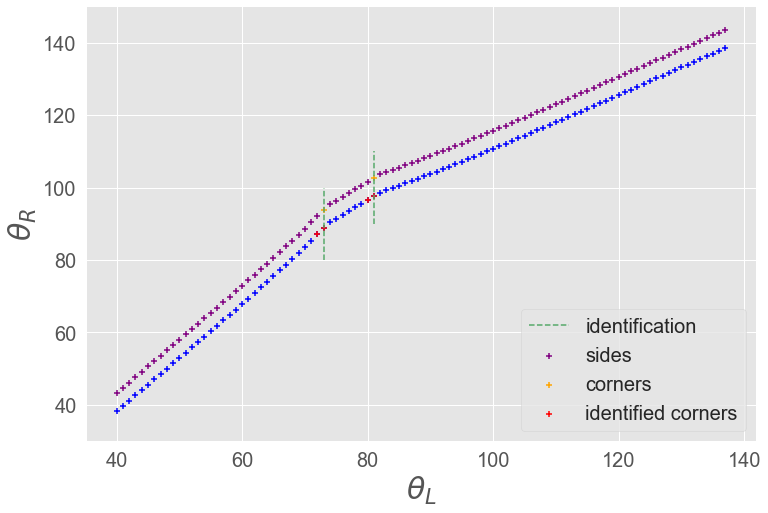

In [85]:
SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=BIGGER_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12,8)
plt.scatter(data_array.T[0][data_array.T[2] == 'side'].astype(float),
            data_array.T[1][data_array.T[2] == 'side'].astype(float)+5,color='purple',marker='+',label='sides')
plt.scatter(data_array.T[0][data_array.T[2] == 'corner'].astype(float),
            data_array.T[1][data_array.T[2] == 'corner'].astype(float)+5,color='orange',marker='+',label='corners')
plt.scatter(angle_array.T[0], angle_array.T[1], 
            color='blue',marker='+')
plt.scatter(identified_corners.T[0],identified_corners.T[1],
            color='red',marker='+',label='identified corners')
plt.plot([identified_corners.T[0][1],identified_corners.T[0][1]],[80,100],'--',color='g',label='identification')
plt.plot([identified_corners.T[0][3],identified_corners.T[0][3]],[90,110],'--',color='g')
plt.ylabel(r'$\theta_R$')
plt.xlabel(r'$\theta_L$')
plt.legend(loc='lower right')
plt.ylim(30,150)
#plt.savefig("corner_id_snd_deriv_1sqr_sim.png")

# Complete the data set

In [95]:
# CREATE A DATAFRAME BY WINDOWING THE RAW AND INCREMENTING THE POSITION OF THE WINDOW
rows,columns = data_array.shape
window_size = 5 # needs to be odd
half_window_size = math.floor(window_size/2)
data_window = np.zeros((rows-half_window_size*2,window_size*2+3)) #+3 for 1st/2nd deriv and the class
corners = []
sides = []

for i in range(half_window_size,rows-half_window_size):
    temp_window = np.append(data_array[i-half_window_size:half_window_size+i+1,:].T[0],
                            data_array[i-half_window_size:half_window_size+i+1,:].T[1])
    temp_window = np.append(temp_window, np.array([gradient[i],double_gradient[i]]))
    if 'corner' in data_array[i-half_window_size:half_window_size+i+1,:].T[2]:
        # CLASS 2 IS THE CORNER
        corners += [angle_array[i].tolist()]
        data_window[i-half_window_size] = np.append(temp_window,np.array([2]))
    else :
        # CLASS 1 IS THE SIDE
        sides += [angle_array[i].tolist()]
        data_window[i-half_window_size] = np.append(temp_window,np.array([1]))

#print(data_window)
names = []
for j in range(window_size):
    names += ["angleLF"+str(j+1)]
for j in range(window_size):
    names += ["angleRF"+str(j+1)]
names += ["1st derivative","2nd derivative","class"]

# DATA FRAME PANDAS
df = pd.DataFrame(data=data_window,columns = names)
df["class"].replace({1.0: "side", 2.0: "corner"}, inplace=True)
df.dropna(how='all', inplace=True)
windows = df[names[:len(names)-1]]
labels = df[names[-1]]

corners_pos = np.array(corners)
sides_pos = np.array(sides)

df.head()
#windows.head()
#labels.head()

,angleLF1,angleLF2,angleLF3,angleLF4,angleLF5,angleRF1,angleRF2,angleRF3,angleRF4,angleRF5,1st derivative,2nd derivative,class
0,40.0,41.0,42.0,43.0,44.0,38.216855,39.705104,41.189086,42.669395,44.146616,1.480,-0.003,side
1,41.0,42.0,43.0,44.0,45.0,39.705104,41.189086,42.669395,44.146616,45.621328,1.477,-0.002,side
2,42.0,43.0,44.0,45.0,46.0,41.189086,42.669395,44.146616,45.621328,47.094103,1.475,-0.002,side
3,43.0,44.0,45.0,46.0,47.0,42.669395,44.146616,45.621328,47.094103,48.565513,1.473,-0.002,side
4,44.0,45.0,46.0,47.0,48.0,44.146616,45.621328,47.094103,48.565513,50.036130,1.471,0.000,side


# LDA with sklearn

In [96]:
# Preparation of the data for LDA
# Standardizing data
X = df.iloc[:, 0:-1].values
le = LabelEncoder()
y = le.fit_transform(df['class'])
print("After formating the data we have: \n X = \n",X[:5],'\n y = \n', y)

# Import LDA from sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda_X = lda.fit_transform(X, y)
print("The explained variance ratio of lda is : ", lda.explained_variance_ratio_)

After formating the data we have: 
 X = 
 [[ 4.0000e+01  4.1000e+01  4.2000e+01  4.3000e+01  4.4000e+01  3.8217e+01
   3.9705e+01  4.1189e+01  4.2669e+01  4.4147e+01  1.4800e+00 -3.0000e-03]
 [ 4.1000e+01  4.2000e+01  4.3000e+01  4.4000e+01  4.5000e+01  3.9705e+01
   4.1189e+01  4.2669e+01  4.4147e+01  4.5621e+01  1.4770e+00 -2.0000e-03]
 [ 4.2000e+01  4.3000e+01  4.4000e+01  4.5000e+01  4.6000e+01  4.1189e+01
   4.2669e+01  4.4147e+01  4.5621e+01  4.7094e+01  1.4750e+00 -2.0000e-03]
 [ 4.3000e+01  4.4000e+01  4.5000e+01  4.6000e+01  4.7000e+01  4.2669e+01
   4.4147e+01  4.5621e+01  4.7094e+01  4.8566e+01  1.4730e+00 -2.0000e-03]
 [ 4.4000e+01  4.5000e+01  4.6000e+01  4.7000e+01  4.8000e+01  4.4147e+01
   4.5621e+01  4.7094e+01  4.8566e+01  5.0036e+01  1.4710e+00  0.0000e+00]] 
 y = 
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
The explaine

In [ ]:
# Plot projection on feature vectors

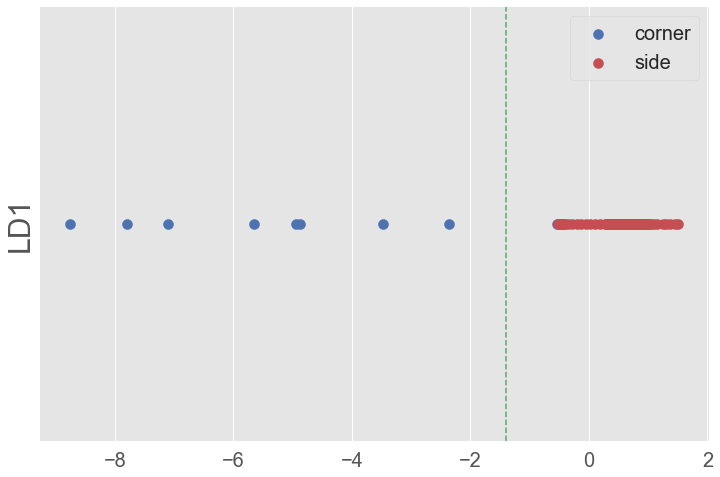

In [98]:
SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax = plt.subplots()
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12,8)
ax.axes.yaxis.set_ticks([])
plt.ylabel('LD1')
plt.scatter(lda_X[y==0], np.full((len(lda_X[y==0]),),1.0), s=100, color='b', label='corner')
plt.scatter(lda_X[y==1], np.full((len(lda_X[y==1]),),1.0), s=100, color='r', label='side')
plt.plot([-1.4,-1.4],[0.9,1.1],'--',color='g')
plt.ylim(0.9,1.1)
ax.legend()
plt.savefig("test.png")